# Models

### Importaciones y preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
import random

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))


from src.preprocessing import load_data, split_features_target, get_column_types, build_preprocessor, prepare_features

df = load_data("C:/Users/Sebastian/Desktop/ProyectoML/bank.csv")

X, y, preprocessor = prepare_features(df, 'y') 

### Reproducibilidad

In [3]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### División de muestra en train y test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify=y,
    random_state=42
)

Usamos stratify = y para que los datos de train y test tengan la misma proporción de valores de y que en el dataset original

### Decision Tree

In [5]:
dt_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

dt_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
y_pred = dt_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       801
           1       0.40      0.48      0.44       104

    accuracy                           0.86       905
   macro avg       0.67      0.69      0.68       905
weighted avg       0.87      0.86      0.86       905



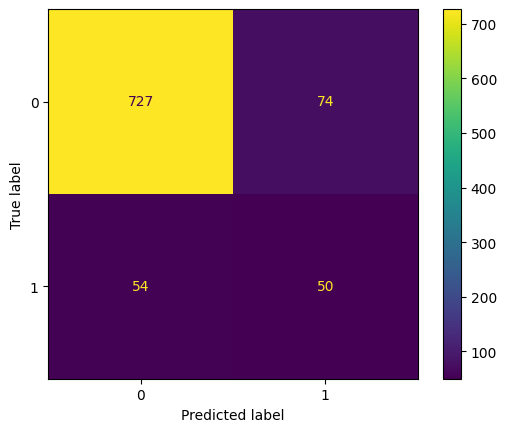

In [7]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Para ser el primer modelo no está mal. Igualmente queremos mejorar las métricas.

Probamos una poda al árbol para evitar overfitting

In [8]:
dt_pruned = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=50,
        random_state=42
    ))
])

dt_pruned.fit(X_train, y_train)

y_pred_dt_pruned = dt_pruned.predict(X_test)
print(classification_report(y_test, y_pred_dt_pruned))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       801
           1       0.54      0.36      0.43       104

    accuracy                           0.89       905
   macro avg       0.73      0.66      0.68       905
weighted avg       0.88      0.89      0.88       905



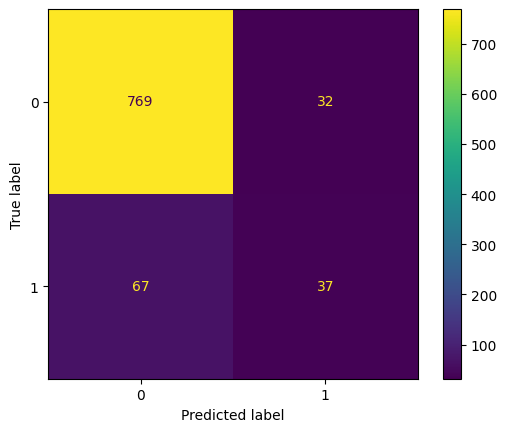

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt_pruned)

Mejora la precisión levemente pero el recall empeora. Por lo tanto, pasamos a otro modelo.

### KNN

In [10]:
knn_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

y_pred_knn = knn_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       801
           1       0.49      0.18      0.27       104

    accuracy                           0.88       905
   macro avg       0.69      0.58      0.60       905
weighted avg       0.85      0.88      0.86       905



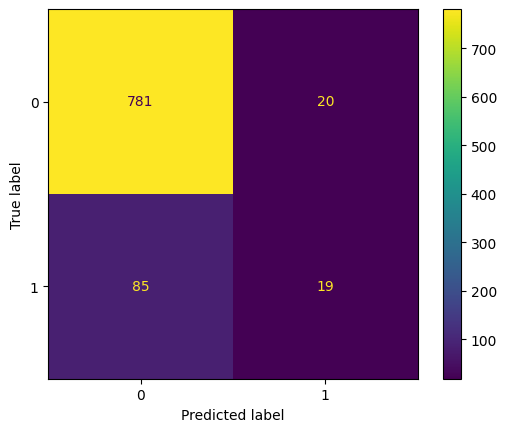

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)

Vamos a probar modelos KNN pero variando la cantidad de vecinos en los que se fija para tomar una decisión

In [12]:
neighbors = [1, 3, 5, 8, 10, 15]

for k in neighbors:
    knn_pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])

    knn_pipeline.fit(X_train, y_train)

    y_pred_knn = knn_pipeline.predict(X_test)
    precision = precision_score(y_test, y_pred_knn, pos_label=1)
    recall = recall_score(y_test, y_pred_knn, pos_label=1)
    f1 = f1_score(y_test, y_pred_knn, pos_label=1)

    print(f'k : {k}')
    print(f' Precision(1)={precision:.3f} | Recall(1)={recall:.3f} | F1(1)={f1:.3f}')

k : 1
 Precision(1)=0.440 | Recall(1)=0.356 | F1(1)=0.394
k : 3
 Precision(1)=0.510 | Recall(1)=0.240 | F1(1)=0.327
k : 5
 Precision(1)=0.487 | Recall(1)=0.183 | F1(1)=0.266
k : 8
 Precision(1)=0.647 | Recall(1)=0.106 | F1(1)=0.182
k : 10
 Precision(1)=0.550 | Recall(1)=0.106 | F1(1)=0.177
k : 15
 Precision(1)=0.522 | Recall(1)=0.115 | F1(1)=0.189


Luego de variar el número de vecinos, se observa que los resultados obenidos no mejoran. Por lo tanto, pasamos a otro modelo

### Random Forest

In [13]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       801
           1       0.47      0.52      0.49       104

    accuracy                           0.88       905
   macro avg       0.70      0.72      0.71       905
weighted avg       0.88      0.88      0.88       905



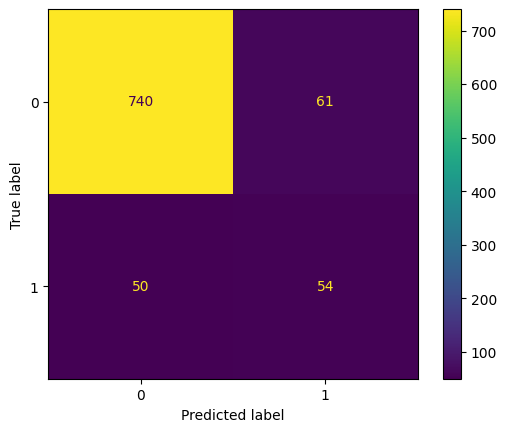

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

Vamos a variar un poco los parámetros a ver si obtenemos mejoras.

In [15]:
maxD = [6,8,10,12,15] #we are going to variete max depth

for md in maxD:
    rf_pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=200,
            max_depth=md,
            min_samples_split = 10,
            min_samples_leaf = 5,
            max_features = 'sqrt', #cuantas variables mira cada split
            class_weight='balanced',
            random_state=42,
            n_jobs = -1 #Para que use todos los nucleos del CPU (más rápido)
        ))
    ])

    rf_pipeline.fit(X_train, y_train)

    y_pred_rf = rf_pipeline.predict(X_test)

    precision = precision_score(y_test, y_pred_rf, pos_label=1)
    recall = recall_score(y_test, y_pred_rf, pos_label=1)
    f1 = f1_score(y_test, y_pred_rf, pos_label=1)

    print(f'max depth : {md}')
    print(f' Precision(1)={precision:.3f} | Recall(1)={recall:.3f} | F1(1)={f1:.3f}')

max depth : 6
 Precision(1)=0.387 | Recall(1)=0.788 | F1(1)=0.519
max depth : 8
 Precision(1)=0.433 | Recall(1)=0.779 | F1(1)=0.557
max depth : 10
 Precision(1)=0.452 | Recall(1)=0.731 | F1(1)=0.559
max depth : 12
 Precision(1)=0.452 | Recall(1)=0.673 | F1(1)=0.541
max depth : 15
 Precision(1)=0.462 | Recall(1)=0.644 | F1(1)=0.538


Observamos una gran mejora en la métrica de recall. Alcanza su pico en max depth = 6. 

### Neural Network.

In [16]:
mlp_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', MLPClassifier(
        hidden_layer_sizes=(50, 25),
        max_iter=500,
        early_stopping=True,
        random_state=42
    ))
])

mlp_pipeline.fit(X_train, y_train)

y_pred_mlp = mlp_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       801
           1       0.51      0.34      0.41       104

    accuracy                           0.89       905
   macro avg       0.72      0.65      0.67       905
weighted avg       0.87      0.89      0.88       905



No se obtienen grandes resultados. Vamos a jugar un poco más con la red

### Deep Neural Network

Transformamos los datos para que sea de tipo float64. De esta manera vamos a poder trabajar con ellos.

In [17]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


X_train_proc.dtype

dtype('float64')

Armamos la red

In [18]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_proc.shape[1],)),
    BatchNormalization(), #entrenamiento mas rapido, estabilidad las dist internas no varian tanto entre epocas.
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(32, activation='relu'),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

c:\Users\Sebastian\Desktop\ProyectoML\venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


En el bloque siguiente preparamos herramientas para que en caso de que la pérdida en validación no disminuya se pare el entrenamiento. Y también antes de que pare se disminuya el learning rate

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

En el siguiente bloque preparamos una herramienta que va a ajustar los pesos del modelo. Si nos equivocamos en la clase minoritaria (1) damos una penalización fuerte

In [20]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

Finalmente entrenamos la red:

In [21]:
history = model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6456 - loss: 0.6078 - precision: 0.2164 - recall: 0.7654 - val_accuracy: 0.8204 - val_loss: 0.5409 - val_precision: 0.3393 - val_recall: 0.7500 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7562 - loss: 0.4852 - precision: 0.3013 - recall: 0.8094 - val_accuracy: 0.8453 - val_loss: 0.4369 - val_precision: 0.3767 - val_recall: 0.7237 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7849 - loss: 0.4442 - precision: 0.3325 - recall: 0.8182 - val_accuracy: 0.8287 - val_loss: 0.3958 - val_precision: 0.3571 - val_recall: 0.7895 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8050 - loss: 0.3938 - precision: 0.3625 - recall: 0.8622 - val_accuracy: 0.8315 - val_loss: 0.3644 - val_precision: 0.3580 - val_recall: 0.7632 - learning_rate: 0.0010
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.801

Predecimos los y que se separaron anteriormente. Luego, como la red devuelve probabilidad de que pertenezca a la clase 1, si es mayor o igual a 0.5 se predice que pertenecerá a la clase 1.

In [22]:
y_pred_prob = model.predict(X_test_proc)
y_pred = (y_pred_prob >= 0.5).astype(int)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       801
           1       0.40      0.70      0.51       104

    accuracy                           0.85       905
   macro avg       0.68      0.78      0.71       905
weighted avg       0.89      0.85      0.86       905



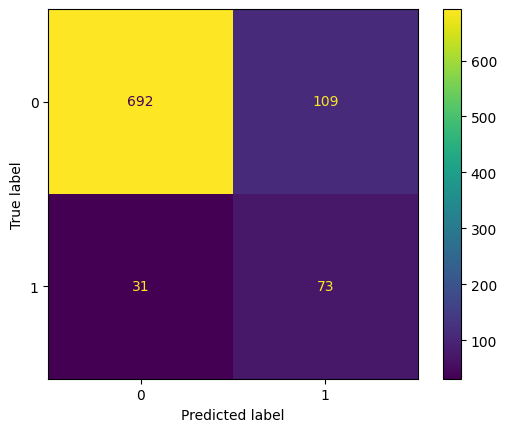

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Se obtienen buenos resultados, similares a los del random forest.

A continuación se observa como evolucionó la perdida en entrenamiento y validación a lo largo del entrenamiento.

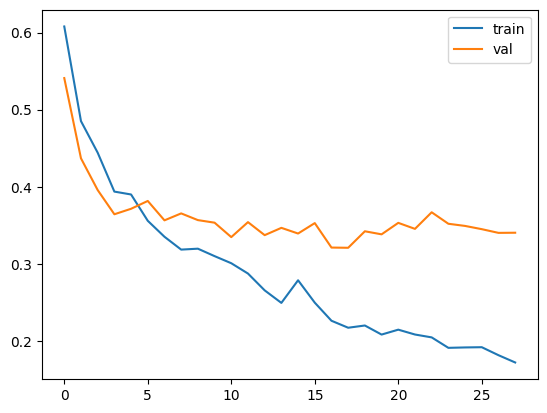

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

**Conclusión**

Luego de entrenar distintos modelos se observa que los que ofrecieron mejores resultados son Random Forest y Deep Neural Network. En el notebook "cross-validation.ipynb" vamos a llevar a cabo un proceso de cross-validation para testear estos modelos.